# Single Dish Radio Example

In [1]:
from numpy import *
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import Image


 The KAT-7 and MeerKAT telescopes are controlled and monitored via Python.
 
 Look at the commissioning data and images in this presentation: https://safe.nrao.edu/wiki/pub/Cville/SaspoVisitNov2010/0_Commissioning-9nov10.pdf
 
 iPython notebooks for analyzing the commissioning data are here:
 https://github.com/ska-sa/tutorials
 
 This tutorial is a fairly heavy edit of the original tutorials. However, the main theme and purpose is followed.

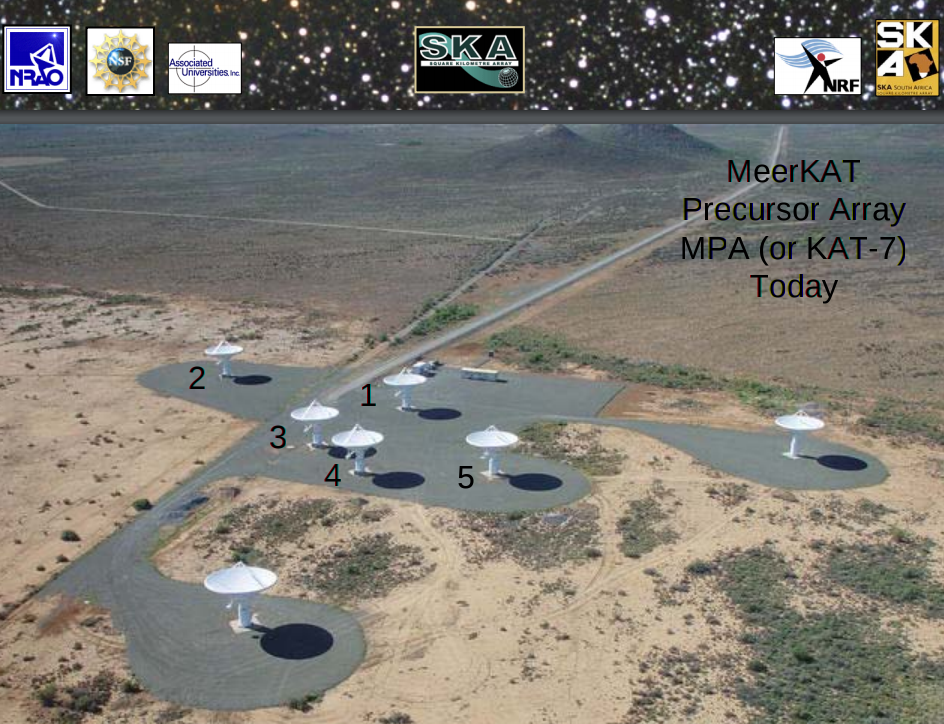

In [2]:
Image(filename='radio12.png')

- Now load the data to be used for the rest of the tutorial into your workspace:

In [3]:
data = load('single_dish_tutorial.npz')

In [4]:
for key, value in data.items():
    savetxt("/u/home/christoq/radio_inter_demo/tutorials/1_Introduction_to_Radio_Astronomy/" + key + ".csv", value)

FileNotFoundError: [Errno 2] No such file or directory: '/u/home/christoq/radio_inter_demo/tutorials/1_Introduction_to_Radio_Astronomy/raster_dec.csv'

We have loaded the data from a zipped set of numpy arrays on disk. The contents of the zipped set may be inspected by:


In [ ]:
data.files

# The Data

What are each of these files? There are three time series: a raster, a scan, and a calibration(nd). Starting with the latter, the nd_power is a short time series of the data once a known calibration source is turned on and then off. There is then a scan (in azimuth) across the astronomical source. To make sense of this, there is also a file which contains the azimuth of each read of the scan. Finally, there is a "raster", which is like taking a bunch of images on a predefined grid across the image. 

# The radiometer

The most basic operation of a single-dish radio telescope is to act as a *radiometer*, which measures the received radio-frequency power from various regions of the sky and as a function of time. If this operation is done simultaneously in multiple frequency bands, the instrument is called a *spectrometer*.

Measuring power
---------------

A typical recording of voltage data produced by a radio telescope pointed at a celestial source (so-called *Gaussian* noise) looks like this:

In [ ]:
x = random.randn(500)
plt.plot(x)

The radiometer estimates the power of this voltage signal by squaring and averaging the sample values. This process is repeated on long runs of consecutive samples (up to several seconds in length), producing a time series of power measurements. This time series is the starting point of our analysis.

Noise diode calibration
-----------------------

First off, we have to calibrate the units of the data. The power values produced by the telescope are 16-bit numbers which range from -32768 to 32767. These values are uncalibrated, with a unit that is traditionally called *counts*. We need to convert this to a physical unit of power. The standard unit is the watt, but celestial radio sources are so weak that it is not very useful. The power measurement can be expressed as a *temperature* in kelvin (K) instead, through the relation

\begin{equation}
  P = \text{k}TB, \quad \text{[W]}
\end{equation}

where $P$ is the power in watts, $\text{k} = 1.3806504 \times 10^{-23}$ is Boltzmann's constant, $T$ is the temperature in kelvin and $B$ is the bandwidth in Hz. The advantage of temperature is that it is independent of bandwidth, while the power of a noise signal increases with increasing bandwidth.

The first step in calibration is to figure out the *receiver (or electronic) gain* which exists between the feed horn of the antenna and the voltage output. This is done by firing a noise diode, which is a calibrated noise source with a known and stable temperature, at the input of the feed horn and observing the increase in measured power. This allows us to determine the receiver gain in counts per kelvin. The data was recorded using one of the KAT-7 dishes, in a frequency band centered at 1836 MHz and with a bandwidth of 222 MHz. 

- Now plot the time series that contains a noise diode switching on and off:

In [ ]:
counts_total = data['nd_power']
plt.plot(counts_total)
plt.show()

- Given that the noise diode temperature was 3.7 K, estimate the receiver gain in counts/K. Use the code cell below as your calculator!

In [ ]:
#Power = counts*G
#G*counts = kTB
k = 1.38e-23
T = 3.7
B = 222e6
counts_source = 6350.0 - 6075.
G = k*T*B/counts_source
print "Gain =  ", G, "counts/K"


- Use this gain to estimate the temperature measured while the noise diode was off. This will provide an indication of the *system temperature* or $T_{\text{sys}}$, which is an important measure of the quality of the instrument. A lower system temperature allows the telescope to detect  fainter objects.

In [ ]:
#Power = counts_sys*G
#G*counts_sys = k*T_sys*B
k = 1.38e-23
#T_sys = ?
B = 222e6
counts_sys = 6075.
T_sys = counts_sys*G/(k*B)
print "T_sys = ", T_sys

#equivalently
#R = 6350/6075. 
#Tsys =  -3.7/(1-R)
off = 6075.
on = 6350.
Tdiode = 3.7
Tsys = (off/(on -off))*Tdiode
print "T_sys = ", T_sys

In [ ]:
plt.plot(counts_total*G/(k*B))
plt.show()

In [ ]:
Image(filename='radio13.png')

Linear scan across source
=========================

We know the positions of most strong radio sources very accurately, thanks to decades of observations. In this experiment, we move the dish across the position of a source and observe the measured power. The power increases as we move onto the source and decreases again as we move off it. This bump in power means we detected the source! Radio astronomy is full of bumps and blobs...

- Plot the scan power as a function of azimuth angle (in degrees) as below:

In [ ]:
az = data['scan_az']
power = data['scan_power']
plt.plot(az, power)
plt.xlabel('Azimuth angle (degrees)')
plt.ylabel('Power (counts)')

What we are actually seeing is a convolution of the antenna *beam pattern* and the structure of the source. For a point source like the one shown, the shape of the bump is purely due to the beam pattern. This allows us to measure the properties of this pattern.

Calibration
-----------

The standard flux unit in radio astronomy is the *jansky (Jy)*, where $1\,\text{Jy} = 10^{-26}\,\text{W}\text{m}^{-2}\text{Hz}^{-1}$, used to quantify the *flux density* of the radio source. We therefore need to calibrate our scan from raw counts to temperatures in kelvin, all the way to flux densities in Jy. The conversion from temperature to flux density involves the gain introduced by the collecting area of the dish itself, referred to as *antenna gain*, which is given by

\begin{equation}
  G = \frac{\eta A}{2 \text{k}} \times 10^{-26} \approx \frac{\eta A}{2761}, \quad \text{[K / Jy]}
\end{equation}

where $\eta$ is the efficiency of the dish (less than 1!), $A$ is the dish area in square metres and $\text{k}$ is Boltzmann's constant.

- Estimate the antenna gain for a KAT-7 dish with a diameter of 12 metres and an efficiency of 0.5 (50%).

In [ ]:
A = pi*((12/2.)**2)
n = 0.5
G_ant = A*n/2761.
print "Antenna Gain = ", G_ant

In [ ]:
Image(filename='radio14.png')

- Combined with the receiver gain in the previous section, use this to calibrate the scan power to be in Jy and make a new plot.

In [ ]:
az = data['scan_az']
plt.plot(az,(counts_scan)*G/(G_ant)/(k*B))
plt.show()

Parameter extraction
--------------------

- Estimate the baseline level of the scan (the lowest part), in Jy. This is also known as the *system equivalent flux density*, or SEFD, which is equivalent to the system temperature.

In [ ]:
counts_scan = data['scan_power']
plt.plot(az,(counts_scan)*G/G_ant/(k*B))
plt.xlim(-2,-1)
plt.ylim(3900,4000)
#Estimated at 3965, which in temperature is:


- Estimate the flux density of the source (in Jy) as the height of the peak of the scan above the baseline level.

In [ ]:
plt.plot(az,counts_scan*G/G_ant/(k*B)-3965)
plt.show()
plt.plot(az,counts_scan*G/G_ant/(k*B)-3965)
plt.xlim(-0.1,0.1)
plt.ylim(850,880)
plt.show()
#Estimated peak at 878 Jy

In [ ]:
Image(filename='radio16.png')


In [ ]:
Image(filename='radio15.png')


- Estimate the *beamwidth* in degrees, which the full width of the beam pattern at half of its maximum value, also known as the FWHM. Zoom into the plot by issuing `axis`, `xlim` or `ylim` commands in order to help you read off the width.

In [ ]:
plt.plot(az,counts_scan*G/G_ant/(k*B)-3965)
plt.show()
plt.plot(az,counts_scan*G/G_ant/(k*B)-3965)
plt.xlim(-1.5,0)
plt.ylim(-10,900)
plt.show()
#Estimated half-height is 878/2 = 439
plt.plot(az,counts_scan*G/G_ant/(k*B)-3965)
plt.xlim(-0.53,-0.51)
plt.ylim(435,440)
plt.show()
#Estimated half-width at 0.5225 degrees

# Raster scan image

Single-dish images are built up pixel by pixel by physically scanning the dish across a patch of sky in a grid or *raster* pattern (incidentally the same way your old-fashioned CRT TV builds up its images). These scans are then assembled into the final image. If the raster scan takes a long time or extends over a large region of sky, we have to convert the spherical antenna coordinates (azimuth angle and elevation angle, or right ascension and declination) to a projected plane centred on the target.

In the dataset you will find a raster scan of [Centaurus A](http://en.wikipedia.org/wiki/Centaurus_A), an impressive radio galaxy in the southern sky and one of the brightest celestial radio sources. The data was recorded using one of the KAT-7 dishes, in a frequency band centered at 1836 MHz and with a bandwidth of 222 MHz. The right ascension and declination coordinates have already been converted to a projected plane, and all that is left to do is to plot the image.

- Load the data and plot the individual pointings (in degrees) that make up the raster scan. Also plot the measured power as a function of time, and compare this with the scan from the previous task.

In [ ]:
ra = data['raster_ra']
dec = data['raster_dec']
power = data['raster_power']
plt.plot(ra, dec, '.', markersize=1)
plt.axis('image')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')

In [ ]:
plt.plot(power)
plt.xlabel('Sample index')
plt.ylabel('Flux density (Jy)')

The power plot shows the data as collected over time by the telescope while performing the raster scan over the radio source. In order to make an image, the data needs to be reorganized.

The first step to an image is to *regrid* the measurements onto a regular rectangular (2-dimensional) grid, where each element of the grid corresponds to a pixel. Matplotlib provides a function for this, called ``griddata``.

- Read the help on this function, select a pixel size in degrees (which determines the size of your image) and do the following (ignore the warning message about dateutil):

In [ ]:
from scipy.interpolate import Rbf
pixels = 250.0
# Use the full (ra, dec) range for the plots...
step = (ra.max() - ra.min())/pixels
grid_ra = arange(ra.min(), ra.max(), step)
step = (dec.max() - dec.min())/pixels
grid_dec = arange(dec.min(), dec.max(), step)

print shape(ra), shape(dec), shape(power), shape(grid_ra), shape(grid_dec)
rbf = Rbf(ra, dec, power, function='linear')
grid_ra, grid_dec = meshgrid(grid_ra, grid_dec)
grid_power = rbf(grid_ra, grid_dec)
print shape(grid_power)

#grid_power = griddata((ra, dec), power, (grid_ra, grid_dec))#, method='linear')
#print grid_power
#grid_power =nan_to_num(grid_power)
#print grid_power

There are two popular ways to plot such an image: as a contour plot or a bitmap image. Here are some examples of how to do this:

In [ ]:
plt.contour(grid_ra, grid_dec, grid_power,50)
plt.axis('image')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')

In [ ]:
extent=[grid_ra.min(), grid_ra.max(), grid_dec.min(), grid_dec.max()]
plt.imshow(grid_power, extent=extent, origin='lower')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')

Feel free to modify the above commands. You can change the color scheme of the bitmap image -- for more information, read the ``colormaps?`` help.

The image does not show a lot of detail, compared to say [this image](http://www.cfa.harvard.edu/news/2010/su201049_images.html) of the radio lobes. How would you increase the resolution of the image?